<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1">Описание данных</a></span></li><li><span><a href="#Импорт" data-toc-modified-id="Импорт-2">Импорт</a></span></li><li><span><a href="#Загрузка-и-знакомство-с-данными" data-toc-modified-id="Загрузка-и-знакомство-с-данными-3">Загрузка и знакомство с данными</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4">Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Обработка-пропусков-в-остальных-признаках" data-toc-modified-id="Обработка-пропусков-в-остальных-признаках-4.1">Обработка пропусков в остальных признаках</a></span></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-4.2">Объединение таблиц</a></span></li></ul></li><li><span><a href="#Метрики-качества" data-toc-modified-id="Метрики-качества-5">Метрики качества</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-6">Моделирование</a></span><ul class="toc-item"><li><span><a href="#TfidfVectorizer" data-toc-modified-id="TfidfVectorizer-6.1">TfidfVectorizer</a></span></li><li><span><a href="#BERT-для-эмбедингов" data-toc-modified-id="BERT-для-эмбедингов-6.2">BERT для эмбедингов</a></span></li><li><span><a href="#LaBSE-для-эмбедингов" data-toc-modified-id="LaBSE-для-эмбедингов-6.3">LaBSE для эмбедингов</a></span></li><li><span><a href="#tfidf_matcher" data-toc-modified-id="tfidf_matcher-6.4">tfidf_matcher</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-6.5">KNN</a></span></li><li><span><a href="#Двухэтапная-модель:-грубый-поиск-tfidf_matcher--+-точный-поиск-классификатор-CatBoost" data-toc-modified-id="Двухэтапная-модель:-грубый-поиск-tfidf_matcher--+-точный-поиск-классификатор-CatBoost-6.6">Двухэтапная модель: грубый поиск <code>tfidf_matcher</code>  + точный поиск классификатор <code>CatBoost</code></a></span></li></ul></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-7">Итоги</a></span></li></ul></div>


# Сервис для полуавтоматической разметки товаров

**Задача проекта**

Разработка решения, которое частично автоматизирует процесс сопоставления товаров. Основная идея - предлагать несколько товаров заказчика, которые с наибольшей вероятностью соответствуют размечаемому товару дилера.  Реализуется в виде онлайн сервиса, открываемого в веб-браузере.

**Задача ML-специалистов**

Разработать рекомендательную модель, которая будет предлагать несколько наиболее вероятных вариантов названия товара у заказчика к названию товара, используемомому на сайте дилера. 




## Описание данных
Заказчик предоставил несколько таблиц (дамп БД), содержащих необходимые данные:

1. `marketing_dealer` - список дилеров


2.	`marketing_dealerprice` - результат работы парсера площадок дилеров:
    - `product_key` - уникальный номер позиции;
    -	`price` - цена;
    -	`product_url` - адрес страницы, откуда собраны данные;
    -	`product_name` - заголовок продаваемого товара;
    -	`date` - дата получения информации;
    -	`dealer_id` - идентификатор дилера (внешний ключ к marketing_dealer)
    

3.	`marketing_product` - список товаров, которые производит и распространяет заказчик:
    - `article` - артикул товара;
    -	`ean_13` - код товара (см. EAN 13)
    -	`name` - название товара;
    -	`cost` - стоимость;
    -	`min_recommended_price` - рекомендованная минимальная цена;
    -	`recommended_price` - рекомендованная цена;
    -	`category_id` - категория товара;
    -	`ozon_name` - названиет товара на Озоне;
    -	`name_1c` - название товара в 1C;
    -	`wb_name` - название товара на Wildberries;
    -	`ozon_article` - описание для Озон;
    -	`wb_article` - артикул для Wildberries;
    -	`ym_article` - артикул для Яндекс.Маркета


4.	`marketing_productdealerkey` - таблица матчинга товаров заказчика и товаров дилеров:
    -	`key` - внешний ключ к marketing_dealerprice
    -	`product_id` - внешний ключ к marketing_product
    -	`dealer_id` - внешний ключ к marketing_dealer


## Импорт

In [144]:
# requirments.txt for notebook
# pandas==2.0.0 
# numpy==1.23.5 
# seaborn==0.11.1 
# sklearn==1.2.2 
# matplotlib==3.7.1 
# nltk==3.8.1
# torch==2.1.0
# sentence_transformers==2.2.2
# tqdm==4.65.0
# pymorphy3==1.2.1
# transformers==4.12.5
# joblib==1.2.0
# catboost==1.0.3
# tfidf-matcher==0.3.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import tfidf_matcher as tm
from sklearn.neighbors import NearestNeighbors
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
tqdm.pandas() # для работы progress_apply в пандас

from catboost import CatBoostClassifier, Pool
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

pd.DataFrame.iteritems = pd.DataFrame.items # совместимостоь text_features в catboost и pandas
pd.set_option('display.max_colwidth', None)
sns.set(rc={'figure.figsize':(18,8)}, style="darkgrid")

## Загрузка и знакомство с данными

In [2]:
# загрузка датасетов
DATA_DIR = 'data/'
try:
    dealers_id = pd.read_csv(DATA_DIR + 'marketing_dealer.csv', sep=";")
    data_dealers = pd.read_csv(DATA_DIR +'marketing_dealerprice.csv', sep=";", parse_dates=['date'])
    data_products = pd.read_csv(DATA_DIR + 'marketing_product.csv', sep=";", index_col='Unnamed: 0',)
    data_key = pd.read_csv(DATA_DIR + 'marketing_productdealerkey.csv',  sep=";")  
except:
    delers_id = pd.read_csv('marketing_dealer.csv', sep=";")
    data_dealers = pd.read_csv('marketing_dealerprice.csv', sep=";", parse_dates=['date'])
    data_products = pd.read_csv('marketing_product.csv', sep=";", index_col='Unnamed: 0',)
    data_key  = pd.read_csv('marketing_productdealerkey.csv', sep=';')

In [4]:
# marketing_dealer.csv
dealers_id

,id,name
0,1,Moi_vibor_WB
1,2,Akson
2,3,Bafus
3,5,Castorama
4,6,Cubatora
5,7,Komus
6,9,Megastroy
7,10,OnlineTrade
8,11,Petrovich
9,12,sdvor


В  данных 18 дилеров заказчика, id которые пронумерованы последовательно


In [5]:
# marketing_dealerprice.csv
display(data_dealers.head(), 
        data_dealers.shape, 
        data_dealers.info(), 
        data_dealers.describe(include='all').T,
        data_dealers.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            20416 non-null  int64         
 1   product_key   20416 non-null  object        
 2   price         20416 non-null  float64       
 3   product_url   20182 non-null  object        
 4   product_name  20416 non-null  object        
 5   date          20416 non-null  datetime64[ns]
 6   dealer_id     20416 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.1+ MB


,id,product_key,price,product_url,product_name,date,dealer_id
0,2,546227,233.0,https://akson.ru//p/sredstvo_universalnoe_prosept_universal_spray_500ml/,"Средство универсальное Prosept Universal Spray, 500мл",2023-07-11,2
1,3,546408,175.0,https://akson.ru//p/kontsentrat_prosept_multipower_dlya_mytya_polov_tsitrus_1l/,"Концентрат Prosept Multipower для мытья полов, цитрус 1л",2023-07-11,2
2,4,546234,285.0,https://akson.ru//p/sredstvo_dlya_chistki_lyustr_prosept_universal_anti_dust_500ml/,"Средство для чистки люстр Prosept Universal Anti-dust, 500мл",2023-07-11,2
3,5,651258,362.0,https://akson.ru//p/udalitel_rzhavchiny_prosept_rust_remover_0_5l_023_05/,"Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 023-05",2023-07-11,2
4,6,546355,205.0,https://akson.ru//p/sredstvo_moyushchee_dlya_bani_i_sauny_prosept_multipower_wood_1l/,Средство моющее для бани и сауны Prosept Multipower Wood 1л,2023-07-11,2


(20416, 7)

None

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,20416.0,NaN,NaN,NaN,10350.362363,2.0,5257.75,10361.5,15465.25,20570.0,5912.127932
product_key,20416,1965,44232019,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,20416.0,NaN,NaN,NaN,1257.323521,0.0,308.0,613.0,1207.0,34500.0,2090.632753
product_url,20182,1883,https://api.ozon.ru/composer-api.bx/page/json/v2?url=/seller/552340/products/?brand=140367694&layout_container=default&layout_page_index=4&miniapp=seller_552340&page=3&sold_out_page=1,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,20416,1953,Просепт Bio Lasur антисептик лессирующий защитно-декоративный (900 мл),117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,20416,NaN,NaN,NaN,2023-07-19 20:58:52.288401152,2023-07-11 00:00:00,2023-07-13 00:00:00,2023-07-19 00:00:00,2023-07-26 00:00:00,2023-07-31 00:00:00,NaN
dealer_id,20416.0,NaN,NaN,NaN,8.938627,1.0,3.0,9.0,15.0,18.0,5.72333


0

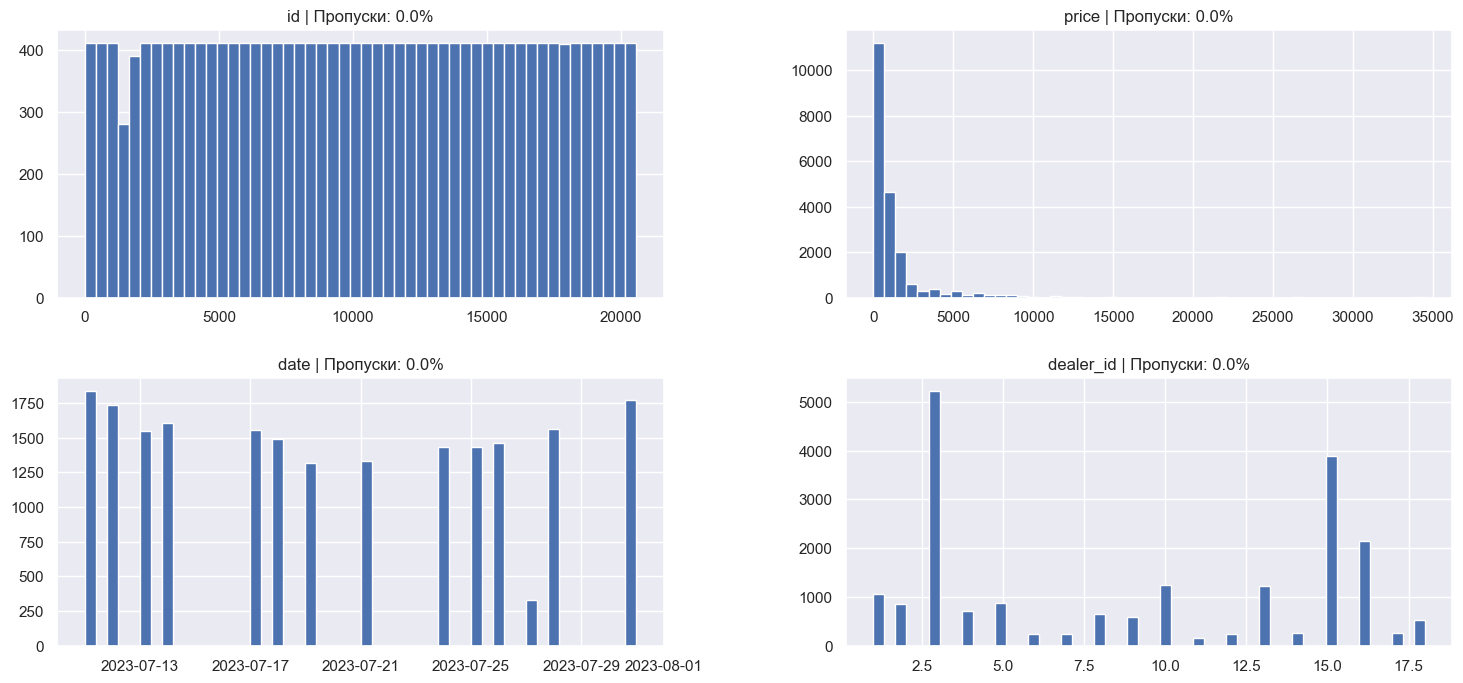

In [6]:
# распределение численных признаков и пропуски
ax = data_dealers.hist(bins=50)
# Добавление подписей с количеством пропусков
for col, subplot in zip(data_dealers.select_dtypes(exclude=['object']).columns, ax.flatten()):
    subplot.set_title(f"{col} | Пропуски: {round(data_dealers[col].isnull().sum()/len(data_dealers) * 100, 2)}%")

In [7]:
data_dealers.drop(['id', 'date', 'product_url', 'price'], axis=1).duplicated().sum()

17392

- всего 20416 записей, из них 17392 записи дублируют продукты, спарсенные в другой день (если удалить дату и id)
- Количество уникальных наименований столбца product_name:  1953
- `product_key` в object, необходимо будет проверить все ли записи содержат только цифры
- Есть нули в цене, самая большая 34500
- Имеются пропуски в столбце product_url (1,2%)
- Распределение товаров по дилерам отличается
- Предоставлены данные парсинга за июль 2023 года



In [8]:
# 'marketing_product.csv
display(data_products.head(), 
        data_products.shape, 
        data_products.info(), 
        data_products.describe(include='all').T,
        data_products.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 0 to 495
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 496 non-null    int64  
 1   article            496 non-null    object 
 2   ean_13             464 non-null    float64
 3   name               494 non-null    object 
 4   cost               491 non-null    float64
 5   recommended_price  491 non-null    float64
 6   category_id        447 non-null    float64
 7   ozon_name          458 non-null    object 
 8   name_1c            485 non-null    object 
 9   wb_name            455 non-null    object 
 10  ozon_article       365 non-null    float64
 11  wb_article         340 non-null    float64
 12  ym_article         337 non-null    object 
 13  wb_article_td      32 non-null     object 
dtypes: float64(6), int64(1), object(7)
memory usage: 58.1+ KB


,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
0,245,008-1,4.680008e+12,Антисептик невымываемыйPROSEPT ULTRAконцентрат 1:10 / 1 л,360.00,858.0,20.0,"Антисептик невымываемый для ответственных конструкций PROSEPT ULTRA, концентрат, 1 л.","Антисептик невымываемый для ответственных конструкций PROSEPT ULTRA, концентрат, 1 л.","Антисептик невымываемый для ответственных конструкций PROSEPT ULTRA, концентрат, 1 л.",189522705.0,150033482.0,008-1,NaN
1,3,242-12,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,460.16,1075.0,NaN,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,NaN,NaN,NaN,NaN,NaN
2,443,0024-06 с,4.680008e+12,"Герметик акриловый цвет сосна, ф/п 600мл",307.00,644.0,25.0,"Герметик акриловый для швов для деревянных домов, конструкций, изделий PROSEPT цвет сосна, ф/п 600мл","Герметик акриловый цвет сосна, ф/п 600мл","Герметик акриловый для швов для деревянных домов, конструкций, изделий PROSEPT цвет сосна, ф/п 600мл",189522735.0,150126217.0,0024-06-с,NaN
3,147,305-2,4.610093e+12,Кондиционер для белья с ароматом королевского ИрисаCrystal Rinserконцентрат / 2 л,157.73,342.0,29.0,"Кондиционер для белья ""Королевский Ирис"" Prosept Crystal Rinser, 2 л.","Кондиционер для белья ""Королевский Ирис"" Prosept Crystal Rinser, 2 л.","Кондиционер для белья ""Королевский Ирис"" Prosept Crystal Rinser, 2 л.",339377922.0,150032962.0,305-2,NaN
4,502,0024-7 б,NaN,"Герметик акриловой цвет Белый, 7 кг",NaN,NaN,NaN,NaN,NaN,NaN,189522867.0,150126216.0,0024-7-б,NaN


(496, 14)

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,496.0,NaN,NaN,NaN,251.320565,147.092825,1.0,124.75,248.5,377.25,513.0
article,496,496,008-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ean_13,464.0,NaN,NaN,NaN,4667049822645.542969,27196558445.528442,4610093420010.0,4680008140430.25,4680008144209.5,4680008147203.5,4680008149985.0
name,494,487,"Герметик акриловый цвет Орех, 3 кг",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cost,491.0,NaN,NaN,NaN,880.162709,1245.260825,44.0,201.0,409.0,839.5,8011.0
recommended_price,491.0,NaN,NaN,NaN,1880.37279,2518.474824,0.0,436.0,891.0,1799.5,14980.0
category_id,447.0,NaN,NaN,NaN,34.342282,10.584979,20.0,25.0,33.0,41.0,57.0
ozon_name,458,454,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name_1c,485,473,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wb_name,455,451,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0

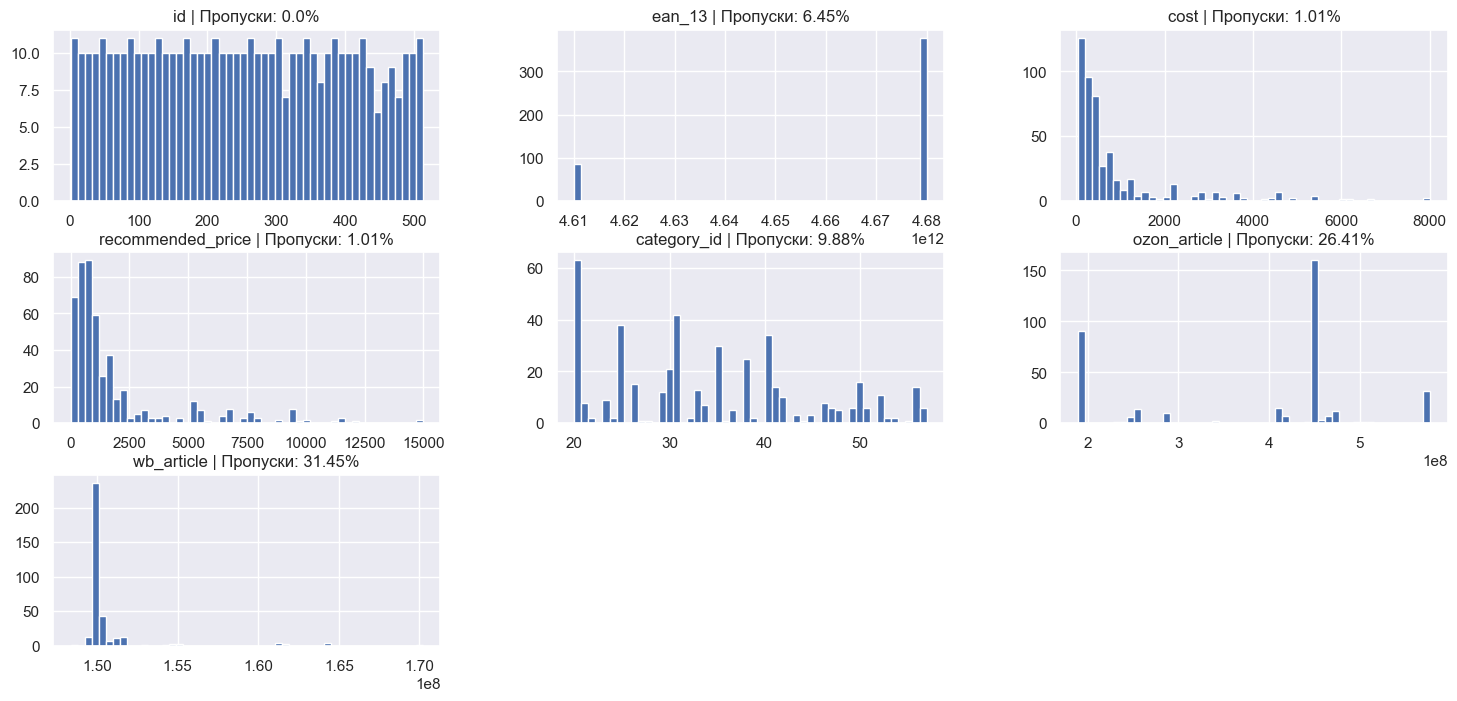

In [9]:
# распределение численных признаков и пропуски
ax = data_products.hist(bins=50)
# Добавление подписей с количеством пропусков
for col, subplot in zip(data_products.select_dtypes(exclude=['object']).columns, ax.flatten()):
    subplot.set_title(f"{col} | Пропуски: {round(data_products[col].isnull().sum()/len(data_products) * 100, 2)}%")

In [10]:
# уникальных значений id
len(data_products['id'].unique())

496

In [11]:
# отсутствует name
data_products[data_products['id'].isin([436, 503, 504])]

,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
23,503,0024-7 о,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150126213.0,NaN,NaN
35,504,w022-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,436,Р1 09005,4.680008e+12,,500.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Уникальных значений `id` 496 в диапазоне 1 - 513
- `category_id`  целое число от 20 до 57, попробуем восстановить 10% пропусков
- Критичные пропуски в признаках `name` и `name_1c`. Строки с пропусками в name удалим (id 436, 503, 504). По комментарию заказчика - для подбора используем признак name_1c, пропуски в нём  заполним данными из name. 
- Есть 0 в рекомендованной цене
- Много пропусков в артикулах для маркетплейсов. При этом название название товара для маркетплейса есть. Предположим, что пропуски это товары, которые на них не продаются.  
wb_article_td - не указанный в описании признак. Для решения задачи признаки с артикулами не понадобятся
- Нет указанного в описании признака минимальная цена
- Явных строк-дубликатов нет



- Названия товаров:
    - В наименованих иногда пропущены пробелы между слов.
    - В названиях товаров присутствуют обьем, количество штук в упаковке и концентрация продукция. Также у каждого обьема разная единица измерения. Эти данные можно извлечь и зафиксировать в отдельные столбцы в качестве дополнительных признаков.

In [722]:
# рекомендуемая цена равна нулю
data_products[data_products['recommended_price']==0]

6 продуктов одной категории имею рекомендуемую цену 0. Заказчик прокоментировал, что это могут быть продукты, который на момент выгрузки выводятся или добавляются в ассортимент. Пока оставляем, так как признак второсттепенный 

In [723]:
# пропуски в цене
data_products[data_products['cost'].isna()]

In [14]:
# marketing_productdealerkey.csv
display(data_key.head(), data_key.shape, data_key.info(), data_key.describe(include='all').T,
       data_key.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1700 non-null   int64 
 1   key         1700 non-null   object
 2   dealer_id   1700 non-null   int64 
 3   product_id  1700 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 53.2+ KB


,id,key,dealer_id,product_id
0,1,546227,2,12
1,2,651265,2,106
2,3,546257,2,200
3,4,546408,2,38
4,5,651258,2,403


(1700, 4)

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1700.0,NaN,NaN,NaN,1063.140588,615.283828,1.0,425.75,1173.5,1598.25,2023.0
key,1700,1700,546227,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dealer_id,1700.0,NaN,NaN,NaN,10.148824,5.830717,1.0,3.0,10.0,15.0,18.0
product_id,1700.0,NaN,NaN,NaN,223.564118,132.341778,1.0,110.0,239.5,334.25,479.0


0

In [15]:
# уникальных значений id
len(data_key['product_id'].unique())

438

In [16]:
# уникальных комбинаций key - product_id
len(data_key[['key','product_id']].value_counts())

1700

Таблица хранит уже найденные соответствия названий дилеров с названиями товаров заказчика.
- 1700 уникальных значений ключей для названий дилеров и 438 уникальных значений id продуктов заказчика. При этом
    - в таблице с инфо от дилеров всего 1965 уникальных ключей
    - в таблице с продуктами производителя 496 уникальных id товаров
- Признак key опять имеет строковый тип данных, далее проверим причину
- Дубликатов нет


In [17]:
# уникальных ключей, не указанных в номенклатуре производителя
dealers = set([x for x in data_dealers['product_key']])
products = set([x for x in data_key['key']])
print('Ключи из таблицы спарсенных данных, которых нет в таблице ключей: ', len(dealers - products))

Ключи из таблицы спарсенных данных, которых нет в таблице ключей:  363


В таблице со спарсенными данными marketing_dealerprice.csv есть 363 значения ключей, которые отсутствуют в датасете с ключами. Как следствие мы имеем 2849 спарсенных названий без указания правильного названия, используемого у производителя. Эти данные не будем использовать в работе


In [18]:
# key имеет формат object, проверим все ли знаки в ключах являются цифрами
contains_non_digits = data_key['key'].apply(lambda x: any(c.isalpha() for c in x))
data_key[contains_non_digits]

,id,key,dealer_id,product_id
431,739,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/sprey_dlya_ochistki_polkov_v_banyakh_i_saunakh_universal_wood_0_5l/,6,20
432,740,https://kub02.ru/catalog/prosept/antiseptik_universalnyy_dlya_vnutr_i_naruzhn_prosept_universal_1l/,6,259
433,741,https://kub02.ru/catalog/prosept/antiseptik_nevymyvaemyy_korichnevyy_prosept_ultra_kontsentrat_1_10_1l/,6,249
434,742,https://kub02.ru/catalog/prosept/lak_dlya_bani_i_sauny_termostoykiy_akrilovyy_prosept_0_9l/,6,321
435,743,https://kub02.ru/catalog/prosept/antiseptik_nevymyvaemyy_korichnevyy_prosept_eco_ultra_gotovyy_sostav_5l/,6,275
436,744,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_tsementa_prosept_cement_cleaner_1l/,6,401
437,745,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/universalnyy_pyatnovyvoditel_prosept_candy_0_5l/,6,162
438,746,https://kub02.ru/catalog/prosept/antiseptik_nevymyvaemyy_korichnevyy_prosept_ultra_kontsentrat_1_10_5l/,6,250
439,747,https://kub02.ru/catalog/prosept/maslo_dlya_zashchity_polkov_prosept_sauna_oil_gotovyy_sostav_0_25l/,6,320
440,748,https://kub02.ru/catalog/prosept/otbelivatel_dlya_drevesiny_prosept_50_1_1_1l/,6,240


In [19]:
# аналогичная проверка в таблице от дилеров
contains_non_digits2 = data_dealers['product_key'].apply(lambda x: any(c.isalpha() for c in x))
data_dealers[contains_non_digits2]

,id,product_key,price,product_url,product_name,date,dealer_id
703,700,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/sprey_dlya_ochistki_polkov_v_banyakh_i_saunakh_universal_wood_0_5l/,297.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/sprey_dlya_ochistki_polkov_v_banyakh_i_saunakh_universal_wood_0_5l/,"Спрей для очистки полков в банях и саунах Universal Wood, 0,5л",2023-07-11,6
704,701,https://kub02.ru/catalog/prosept/antiseptik_universalnyy_dlya_vnutr_i_naruzhn_prosept_universal_1l/,748.0,https://kub02.ru/catalog/prosept/antiseptik_universalnyy_dlya_vnutr_i_naruzhn_prosept_universal_1l/,"Антисептик универсальный для внутр. и наружн. PROSEPT UNIVERSAL, 1Л",2023-07-11,6
705,702,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_vysolov_prosept_salt_cleaner_1l_sostav_1_2/,613.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_vysolov_prosept_salt_cleaner_1l_sostav_1_2/,Удалитель высолов PROSEPT SALT CLEANER (1л) состав 1:2,2023-07-11,6
706,703,https://kub02.ru/catalog/kraska_i_gruntovka/kraska_grunt_fasadnaya_dlya_plit_osb_proff_3v1_1kg_prosept/,487.0,https://kub02.ru/catalog/kraska_i_gruntovka/kraska_grunt_fasadnaya_dlya_plit_osb_proff_3v1_1kg_prosept/,Краска-грунт фасадная для плит OSB Proff 3в1 (1кг) PROSEPT,2023-07-11,6
707,704,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_tsementa_prosept_cement_cleaner_1l/,569.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_tsementa_prosept_cement_cleaner_1l/,"Удалитель цемента PROSEPT CEMENT CLEANER ,1Л",2023-07-11,6
...,...,...,...,...,...,...,...
19195,19345,https://kub02.ru/catalog/prosept/antiseptik_dlya_bani_i_sauny_prosept_sauna_1_10_1l/,755.0,https://kub02.ru/catalog/prosept/antiseptik_dlya_bani_i_sauny_prosept_sauna_1_10_1l/,"Антисептик для бани и сауны PROSEPT SAUNA 1:10, 1л",2023-07-31,6
19196,19346,https://kub02.ru/catalog/prosept/ognebiozashchita_dlya_drevesiny_prosept_2_gruppa_s_indikatorom_gotovyy_sostav_10_kg/,888.0,https://kub02.ru/catalog/prosept/ognebiozashchita_dlya_drevesiny_prosept_2_gruppa_s_indikatorom_gotovyy_sostav_10_kg/,"Огнебиозащита для древесины PROSEPT, 2 группа с индикатором, готовый состав, 10 кг",2023-07-31,6
19197,19347,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_rzhavchiny_prosept_rust_remover_gotovyy_sostav_0_5l/,396.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_rzhavchiny_prosept_rust_remover_gotovyy_sostav_0_5l/,"Удалитель ржавчины PROSEPT RUST REMOVER готовый состав 0,5Л",2023-07-31,6
19198,19348,https://kub02.ru/catalog/emali/propitka_dlya_kamnya_gidrofobiziruyushchiy_sostav_1l_prosept_aquaisol_sostav_1_2_/,406.0,https://kub02.ru/catalog/emali/propitka_dlya_kamnya_gidrofobiziruyushchiy_sostav_1l_prosept_aquaisol_sostav_1_2_/,Пропитка для камня гидрофобизирующий состав (1л) PROSEPT AQUAISOL состав 1:2,2023-07-31,6


Вместо численных ключей у нескольких продуктов указано url в обеих таблицах. Оставляем, так как по ним соединяются таблицы без проблем.

Заказчиком подтверждено, что ключом может быть ссылка

---

**Итоги знакомства с данными**

- Изучено 4 предосттавленные таблицы с данными
- Наша задача подобрать подходящее название из названий товаров заказчика `data_products['name']` ('marketing_dealerprice.csv' - результаты парсинга сайтов дилеров) к спарсенному названию товара у дилера `data_dealers['product_name']` ('marketing_product.csv' - база продуктов заказчика)
- 2048 спарсенных данных не имеют разметку через таблицу 'marketing_productdealerkey.csv', то есть мы не знаем какое название производителя ему соответствует. Такие записи придётся удалить.
- В данных с сайтов дилеров около 80% дубликатов, записи повторяются для одних и тех же товаров, спарсенных в разные дни. В результате для работты остаётся ~2000 сопоставленных пар.
- В данных есть пропуски. Самые критичные в названии продуктов производителя - 3 записи придётся удалить. В итоге будем располагать 493 названиями для подбора подходящего.
- Остальные пропуски будем обрабатывать - `category_id` восстановим, остальные заполним заглушками.
- Предположительные выбросы - нули в ценах пока оставляем как есть
- В названиях товаров используется русские и английские слова, есть пропущенные пробелы,  присутствуют данные об обьеме, количестве штук в упаковке и концентрации. Также у каждого обьема разная единица измерения. Эти данные можно извлечь и зафиксировать в отдельные столбцы в качестве дополнительных признаков.


## Подготовка данных

In [3]:

# Функция для извлечения концентрации, объема, единицы измерения и фасовки из наименования товара в отдельные столбцы.
def extract_info(df, col_name):
    data = df.copy()
    pattern_volume = r'\s*(\d+(?:[.,]\d+)?)\s*([мк]?[лг]|лит[р]?[ы]?|к[г]?[р]?[ам]?[ы]?)\s*'
    pattern_concentration = r'\s*(\d+:\d+)\s*'
    pattern_quantity = r'\s*(\d+)\s*(?:шт(?:ук[и]?|\.)?|ШТ|шт)\s*'

    data['volume'] = data[col_name].str.extract(pattern_volume, expand=True)[0]
    data['units_of_meas'] = data[col_name].str.extract(pattern_volume, expand=True)[1]
    data['concent'] = data[col_name].str.extract(pattern_concentration, expand=False)
    data['units'] = data[col_name].str.extract(pattern_quantity, expand=False)
    
    data['units'].fillna('1', inplace=True)
    data['concent'].fillna('1:1', inplace=True)
    data['volume'].fillna('1', inplace=True)
    data['units_of_meas'].fillna('шт', inplace=True)
    
    # Добавляем ваш фрагмент кода для удаления лишних пробелов между буквой и словом
    data[col_name] = data[col_name].str.replace(r'(\w)\s+(?=\w)', r'\1')

    return data


# Функция для извлечения первых 3-4 слов из названия товара
def extract_keywords(name):
    words = name.split()[:4]
    return ' '.join(words)


In [9]:

# Функция очистки,  токенизации, лемматизации и удаление стоп-слов.
def preprocess_text(text):
    # добавить пропущенные пропуски
    text = re.sub(r'(?<=[a-zA-Z])(?=[а-яА-ЯёЁ])|(?<=[а-яА-ЯёЁ])(?=[a-zA-Z])', ' ', text)
    text = re.sub(r'(\S)\*(\S)', r'\1 * \2', text)
    text = re.sub(r'(\d+)([а-яА-ЯёЁa-zA-Z]+)', r'\1 \2', text)
    
    text = re.sub(r'\b\d+-\d+\b', '', text) # Удаление артикула типа "152-5" в конце строки  r'\s*\d+-\d+$'
    
    text = text.lower()
    
    # в наименования оказались еще места, которые не были обработаны функцией и уберем эти проблемы вручную
    text = (text
           .replace('с редство', 'средство')
           .replace('бетонконтактготовый', 'бетонконтакт готовый')
           .replace('"к', '" к')
           .replace('яблокаконцентрированное', 'яблока концентрированное')
           .replace('(сухой остаток 20%)', ' (сухой остаток 20%) ')
           .replace('цитрусаконцентрат', 'цитруса концентрат')
           .replace('.с', '. с')
           .replace('50концентрат', '50 концентрат')
           )
#----------------------
#     # вытаскиваем признаки концентрации, объема, единицы измерения и фасовки из наименования товара
#     pattern_volume = r'\s*(\d+(?:[.,]\d+)?)\s*([мк]?[лг]|лит[р]?[ы]?|к[г]?[р]?[ам]?[ы]?)\s*'
# #     pattern_volume =  r'\b(\d+(?:[.,]\d+)?)\s*([мк]?[лг]?|[кг]?г?р?[ам]?[ы]?|лит[р]?[ы]?)\b'
#     pattern_concentration = r'\s*(\d+:\d+)\s*'
#     pattern_quantity = r'\s*(\d+)\s*(?:шт(?:ук[и]?|\.)?|ШТ|шт)\s*'
    
#     # сначала извлекём количество штук в наборе  и концентрацию
#     units = (re.search(pattern_quantity, text).group(1)  + ' штука'
#           if re.search(pattern_quantity, text)
#           else '')
    
#     concent = (re.search(pattern_concentration, text).group(1)
#               if re.search(pattern_concentration, text)
#               else '')
    
    
#     volume = (re.search(pattern_volume, text).group(1) 
#               if re.search(pattern_volume, text) 
#               else '')
#     volume = volume.replace(',', '.')

#     units_of_meas = (re.search(pattern_volume, text).group(2) 
#                       if re.search(pattern_volume, text)
#                       else '')

#     # заменить мл на л
#     if units_of_meas == 'мл':
#         units_of_meas = 'л'
#         volume =  "{:.1f}".format(float(volume) / 1000)
    

    
    # Очистка текста
#     text = re.sub(pattern_volume, ' ', text)
#     text = re.sub(pattern_concentration, ' ', text)
#     text = re.sub(pattern_quantity, ' ', text)
#---------------------------------------------------------------------------------

    text = re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9 ,.:]", ' ', text)
    text = re.sub(r"[,]", '.', text) 
    text = re.sub(r'\.\s', ' ', text) # если точка после пробела

    # уберём название производителя
    text = text.replace('prosept', '').replace('просепт', '')
    
    # Токенизация
    tokens = word_tokenize(text)
    
    # лемматизация русских слов
    morph = pymorphy3.MorphAnalyzer()
    lemmas = [morph.parse(word)[0][2] for word in tokens]

    # Удаление стоп-слов - улучшает
    stop_words = set(stopwords.words('russian') + stopwords.words('english'))
    filtered_words = [lemma for lemma in lemmas if lemma not in stop_words]

    # Возвращение предобработанного текста
    cleaned_name =  ' '.join(filtered_words)

    # стандартизация порядка написания в названии объёма и тд - ухудшает
    feature =  cleaned_name #+ ' ' + concent + ' ' + volume + ' ' + units_of_meas + ' ' + units
    
    return feature

# проверка работы функции
product_name = 'Средство моющее для бани и сауны Prosept Multipower Wood, ral 9002 152-52 1:1 1,65 л '
preprocess_text(product_name)

'средство моющий баня сауна multipower wood ral 9002 1:1 1.65 л'

In [10]:
# ключи в data_dealers содержат лишний пробел в начале, уберём пробелы чтобы увеличить число сопоставленных пар
mask = data_dealers['product_key'].str.startswith(' ')
data_dealers.loc[mask, 'product_key'] = data_dealers.loc[mask, 'product_key'].str.lstrip()

In [11]:
# удалить продукты дубликаты, спарсенные в разные дни
data_dealers = data_dealers[~data_dealers.drop(['id', 'date', 'product_url', 'price'], axis=1).duplicated()]
data_dealers.shape

(1994, 7)

**Обработка признаков с текстовыми названиями**

 **`data_products`**

In [12]:
data_products.isna().sum()

id                     0
article                0
ean_13                32
name                   2
cost                   5
recommended_price      5
category_id           49
ozon_name             38
name_1c               11
wb_name               41
ozon_article         131
wb_article           156
ym_article           159
wb_article_td        464
dtype: int64

In [13]:
# пропуски в столбце name заполнить значениями в столбце name_1c (если есть)
data_products['name'] = data_products['name'].fillna(data_products['name_1c'])

In [14]:
# удалитть пропуски в name
data_products = data_products.dropna(subset=['name'])

# удалили одно название пустое
empty_name_rows = data_products[data_products['name'].str.contains(r'^\s*$')]
data_products = data_products.drop(index=empty_name_rows.index)

In [15]:
#  обьем, количество штук в упаковке, концентрация продукция, разная единица измерения
# извлечь и зафиксировать в отдельные столбцы в качестве дополнительных признаков
data_products = extract_info(data_products, 'name')

In [16]:
# очистка текста названий производителя
data_products['feature'] =  (data_products['name'].progress_apply(preprocess_text))

100%|██████████| 493/493 [01:51<00:00,  4.43it/s]


 **`data_dealers`**

In [17]:
# очистка текста названий с сайтов дилеров
data_dealers['dealer_feature'] =  (data_dealers['product_name'].progress_apply(preprocess_text))

100%|██████████| 1994/1994 [08:14<00:00,  4.03it/s]


### Обработка пропусков в остальных признаках

In [18]:
# Заполнение пропущенных значений в категориях на основе группировки по первым 3-4 словам в названиях товаров
data_products['category_id'].fillna(data_products['name'].apply(extract_keywords), inplace=True)

In [19]:
# Для пропусков в ценах поставим просто заглушку -1
data_products['cost'].fillna('-1', inplace=True)
data_products['recommended_price'].fillna('-1', inplace=True)

In [724]:
(data_products.isna().sum() / len(data_products)).to_frame().style.background_gradient()

### Объединение таблиц
Для дальнейшего сопоставления объединим в общую таблицу данные с названиями дилеров и сопоставленные им названиями производителя. 

Оставляем только признаки с названиями и ключами, id 
- из data_dealers: `product_key`, `product_name`, `dealer_feature`
- из data_products:  `id`,`name`, `feature`, 


In [20]:
#  оставляем необходимый набор признаков 
# соединим ключи по id с названиями производителя
product_with_key_data = data_key[['key', 'product_id']].merge(
    data_products[['id', 'name', 'feature']],
    how='left', 
    right_on='id', 
    left_on='product_id'
)
# к датасету с названиями дилеров присоединим наззвания производителя 
full_data = data_dealers[ ['product_key', 'product_name', 'dealer_feature']].merge( 
    product_with_key_data, 
    how='left', 
    right_on='key', 
    left_on='product_key').drop(['product_id', 'product_key'], axis=1)
print(full_data.shape)
full_data.sample(2)

(1994, 6)


,product_name,dealer_feature,key,id,name,feature
224,Просепт Огнебио Prof 1 огнебиозащита для древесины (65 л) бесцветная,огнебио prof 1 огнебиозащита древесина 65 л бесцветный,200671267,305.0,"Огнебиозащита ОГНЕБИО PROF l, 1 группа, бесцветный готовый состав / 65 л",огнебиозащита огнебио prof l 1 группа бесцветный готовый состав 65 л
997,Антисептик PROSEPT ХМ-11 невымываемый ГОСТ 5 л 065-5,антисептик хм 11 невымываемый гост 5 л,20633236,409.0,"Антисептик невымываемый ХМ-11, ГОСТ / 5 л",антисептик невымываемый хм 11 гост 5 л


In [21]:
full_data.isna().sum()

product_name        0
dealer_feature      0
key               303
id                303
name              303
feature           303
dtype: int64


В объединённом очищенном датасете 303 строки с отсутствующей разметкой, которые придётся удалить.
Похоже, это просто неразмеченные записи. Среди них есть несколько с припиской "Уцененный товар".

In [22]:
#  удалим неразмеченные записи и перезапишем индексы
full_data = full_data.dropna().reset_index(drop=True)
data_products = data_products.reset_index(drop=True)
data_dealers = data_dealers.reset_index(drop=True)

## Метрики качества
Особенности решаемой задачи ранжирования:
- существует только одно правильное соответствующее название товара среди названий производителя
- заказчик не указал конкретное количество выводимых рекомендаций (запросил настраиваемое количество)

Для оценки возьмём набор метрик:
- **accuracy@1** - доля случаев, когда предсказано правильное название 
- **accuracy@5** - доля случаев, когда правильное название присутствует в топ-5 предсказанных
- **accuracy@10** - доля случаев, когда правильное название присутствует в топ-10 предсказанных
- **accuracy@20** - доля случаев, когда правильное название присутствует в топ-20 предсказанных (для оценки использования в двухэтапной модели)
- **Mean Reciprocal Rank (MRR)** -  измеряет, на какой позиции в среднем находится релевантный результат в ранжированном списке относительно первого, в нашем случае состоящем из 10 элементов. 
Формула MRR для одного запроса: $MRR = 1 / rank$, где *rank* - ранг первого релевантного результата. Более высокое значение MRR указывает на более эффективное ранжирование.



(В условиях нашей задачи recall@5 вычисляется также как accuracy@5, а preciision@5 не показательна, так как имеет максимум 20%)


In [23]:
def calculate_accuracy_a_k(y_true, y_pred_k_in_array, k=10):
    """
    Расчёт метрики качества Accuracy at K.

    Parameters:
        y_true (array-like): Истинные значения.
        y_pred_k_in_array (array-like): Массив с k рекомендаций.
        k (int): Количество первых рекомендаций для учета в расчете.

    Returns:
        float: Значение Accuracy at K в процентах.
    """
    acc = 0
    for target, recommendations in zip(y_true.tolist(), y_pred_k_in_array.tolist()):
        acc += int(target in recommendations[:k])
    return 100 * acc / len(y_pred_k_in_array)

In [24]:
def mean_reciprocal_rank(true_id, recommendations, k=10):
    """
    Расчёт метрики Mean Reciprocal Rank (MRR).

    Parameters:
        true_id (array-like or pd.Series): Истинные значения.
        recommendations (array-like or pd.Series): Список k рекомендаций для каждого элемента.
        k (int): Количество элементов для учета в расчете.

    Returns:
        float: Значение Mean Reciprocal Rank (MRR).
    """
    # если передеаётся Series
    if isinstance(true_id, pd.Series):
        true_id = true_id.values
    if isinstance(recommendations, pd.Series):
        recommendations = recommendations.values
    
    reciprocal_ranks = []
    
    for i, rec in enumerate(recommendations):
        recs = rec[:k]
        relevant = true_id[i]
        
        if np.isin(relevant, recs):
            rank = np.where(recs == relevant)[0][0] + 1
            reciprocal_ranks += [1 / rank]
            
        else:
            reciprocal_ranks += [0]
            
    return np.mean(reciprocal_ranks)

In [30]:
# расчёт набора метрик
def calculate_metrics(y_true, y_pred):
    """
    Расчёт набора метрик Accuracy at K: 1, 5, 10, 20 и MRR.

    Parameters:
        y_true (array-like): Истинные значения.
        y_pred_k_in_array (array-like): Массив с k рекомендаций.

    Returns:
        float: 5 значений метрик
    """
    acc1 = round(calculate_accuracy_a_k(y_true, y_pred, k=1), 2)
    acc5 = round(calculate_accuracy_a_k(y_true, y_pred, k=5), 2)
    acc10 = round(calculate_accuracy_a_k(y_true, y_pred, k=10), 2)
    acc20 = round(calculate_accuracy_a_k(y_true, y_pred, k=20), 2)
    mrr = round(mean_reciprocal_rank(y_true, y_pred, k=10), 2)
    
    print(f'Accuracy@1 = {acc1}%\nAccuracy@5 = {acc5}%\nAccuracy@10 = {acc10}%')
    print(f'Accuracy@20 = {acc20}%\nMRR@10 = {mrr}')
    
    return acc1, acc5, acc10, mrr, acc20

## Моделирование
Для решении задачи метчинга названий товаров   
использован подход, в котором текстовые названия переводятся в эмбединги и с помощью метрики схожести подбираются наиболее похожих.

Решено выводить для пользователя 5 рекомендаций.

- В качестве  baseline попробуем модель: `TfidfVectorizer + косинусное сходство из sklearn`

Далее для улучшения попробуем для создания эмбедингов использовать 
- `distilbert` из `sentence_transformers` (+ косинусное сходство `util.pytorch_cos_sim`)
- `LaBSE` из `sentence_transformers` (+ косинусное сходство+ `sklearn`)
- `tfidf-matcher`
- `TF-IDF-vectorizer` + `KNN`
- Двухэтапная модель: грубый поиск 20 рекомендаций одним из вышеуказанных способов + точный поиск классификатор `CatBoost`

Оцениваем по метрикам accuracy@5 (основная), дополнительно accuracy@1, accuracy@10, MRR и accuracy@20 для подбора грубого поиска в двухэтапную модель. Расчёт делаем на всех предоставленных размеченных данных.

На текущей стадии работы для метчинга мы будем использовать только названия продуктов.


### TfidfVectorizer
`TfidfVectorizer + косинусное сходство из sklearn`

In [31]:
K=20
vectorizer = TfidfVectorizer() # ngram_range=(1, 2) ухудшает

# векторные представления
product_tfidf_matrix = vectorizer.fit_transform(data_products['feature'].tolist())
dealers_tfidf_matrix = vectorizer.transform(full_data['dealer_feature'].tolist())

# рассчитываем сходство
cosine_similarities = cosine_similarity(dealers_tfidf_matrix, product_tfidf_matrix)

# Индексы K наиболее близких объектов для каждого дилера
top_n_indices = np.argsort(cosine_similarities, axis=1)[:, ::-1][:, :K]

#  список для записи id рекомендованных продуктов
result_list = []

for index in top_n_indices:
    product_id = data_products.iloc[index]['id'].tolist()
    result_list.append(product_id)
full_data['recommendations_base'] = result_list


In [32]:
tfidf_cos_acc1, tfidf_cos_acc5, tfidf_cos_acc10, tfidf_cos_mrr10, tfidf_cos_acc20 = calculate_metrics(
    full_data['id'], 
    full_data['recommendations_base']
)

Accuracy@1 = 53.16%
Accuracy@5 = 88.7%
Accuracy@10 = 93.73%
Accuracy@20 = 95.56%
MRR@10 = 0.69



### BERT для эмбедингов
Испытаем для создания эмбедингов `distilbert` из `sentence_transformers` + `util.pytorch_cos_sim`



In [135]:
model_bert = SentenceTransformer('distilbert-base-nli-mean-tokens') # - 71.43 на тестовой выборке
# Пробовали:
# bert-base-nli-mean-tokens - 70.46 на тестовой выборке
# bert-base-uncased - 70.46 на тестовой выборке
# bert-base-multilingual-cased - 66.47 на тестовой выборке
# paraphrase-MiniLM-L6-v2 - 66.87 на тестовой выборке

In [33]:
%%time

K=20
model_bert = SentenceTransformer('distilbert-base-nli-mean-tokens')

# векторные представления
corpus_embeddings_bert = model_bert.encode(data_products['feature'].tolist())
dealer_products_embedding = model_bert.encode(full_data['dealer_feature'].tolist())

# Поиск наиболее похожих названий
cosine_scores = util.pytorch_cos_sim(dealer_products_embedding, corpus_embeddings_bert)

# Индексы K наиболее близких объектов для каждого дилера
top_matches_indices = cosine_scores.argsort(descending=True)[:, :K]

#  список для записи id рекомендованных продуктов
result_list_bert = []

for index in top_matches_indices:
    product_id = data_products.iloc[index]['id'].tolist()
    result_list_bert.append(product_id)
full_data['recommendations_bert'] = result_list_bert

CPU times: user 4min 21s, sys: 10 s, total: 4min 31s
Wall time: 3min 14s


In [34]:
bert_acc1, bert_acc5, bert_acc10, bert_mrr10, bert_acc20 = calculate_metrics(
    full_data['id'], 
    full_data['recommendations_bert']
)

Accuracy@1 = 50.33%
Accuracy@5 = 70.55%
Accuracy@10 = 77.71%
Accuracy@20 = 82.61%
MRR@10 = 0.59


### LaBSE для эмбедингов
- Предобученная на русских и английских ттекстах модель `LaBSE` из `sentence_transformers` + косинусное сходство из `sklearn`


In [35]:
# загрузка предообученной модели (en-ru - облегчённая версия)
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model_labse = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
%%time
# функция для создания эмбедингов с помощью LaBSE-en-ru
def labse_embeddings(sentences):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        model_output = model_labse(**encoded_input)
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings

# векторные представления
corpus_embeddings_labse = labse_embeddings(data_products['feature'].tolist())
dealer_products_embedding_labse = labse_embeddings(full_data['dealer_feature'].tolist())

CPU times: user 5min 9s, sys: 37.7 s, total: 5min 47s
Wall time: 3min 45s


In [37]:
K=20
# рассчитываем сходство косинусным расстоянием из sklearn
cosine_similarities = cosine_similarity(dealer_products_embedding_labse, corpus_embeddings_labse)

# Индексы K наиболее близких объектов для каждого дилера
top_n_indices = np.argsort(cosine_similarities, axis=1)[:, ::-1][:, :K]

#  список для записи id рекомендованных продуктов
result_list_labse = []

for index in top_n_indices:
    product_id = data_products.iloc[index]['id'].tolist()
    result_list_labse.append(product_id)
    
full_data['recommendations_labse'] = result_list_labse

In [38]:
labse_acc1, labse_acc5, labse_acc10, labse_mrr10, labse_acc20 = calculate_metrics(
    full_data['id'], 
    full_data['recommendations_labse']
)

Accuracy@1 = 71.32%
Accuracy@5 = 92.25%
Accuracy@10 = 95.39%
Accuracy@20 = 97.63%
MRR@10 = 0.8


### tfidf_matcher
Внутри TF-IDF векторизация + подбор наиболее похожих строк в корпусе на основе косинусного сходства.  
Модель возвращает наиболее близкие строки для каждой строки в исходном корпусе, ранжированные по степени сходства.

In [39]:
K = 20
# модель генерирует таблицу с рекомендациями
tfidf_match_table = tm.matcher(
    original=full_data['dealer_feature'], 
    lookup=data_products['feature'],
    k_matches=K,
    ngram_length=3
)

In [40]:
# из таблицы сложим полученные рекомендации в список
full_rec_index = []
for index in tfidf_match_table.index:
    rec_index = []
    for name in tfidf_match_table.loc[index, ['Lookup ' + str(i) for i in range(1, K+1)]].tolist():
        index_rec = data_products[data_products['feature']==name].index[0]
        rec_index.append(data_products.loc[index_rec, 'id'])
    full_rec_index.append(rec_index)

full_data['tfidf_matcher'] = full_rec_index

# проверка
full_data.sample()

,product_name,dealer_feature,key,id,name,feature,recommendations_base,recommendations_bert,recommendations_labse,tfidf_matcher
772,"Удалитель цемента Prosept Cement Cleaner, концентрат 1:2, 5 л",удалитель цемент cement cleaner концентрат 1:2 5 л,2012882,402.0,Удалитель цемента CEMENT CLEANER концентрат 1:2 / 5 л,удалитель цемент cement cleaner концентрат 1:2 5 л,"[401, 402, 400, 211, 399, 398, 483, 209, 210, 392, 391, 208, 404, 405, 487, 484, 207, 390, 403, 510]","[402, 401, 400, 399, 398, 208, 405, 487, 207, 397, 404, 114, 396, 137, 497, 143, 53, 50, 51, 54]","[402, 401, 400, 399, 398, 405, 211, 404, 392, 104, 391, 487, 407, 120, 208, 122, 15, 29, 483, 121]","[402, 401, 400, 399, 398, 405, 392, 391, 208, 211, 404, 487, 390, 483, 397, 210, 207, 209, 396, 17]"


In [41]:
tfidf_matcher_acc1, tfidf_matcher_acc5, tfidf_matcher_acc10,  tfidf_matcher_mrr, tfidf_matcher_acc20 = (
    calculate_metrics(full_data['id'], full_data['tfidf_matcher'])
)


Accuracy@1 = 70.2%
Accuracy@5 = 90.89%
Accuracy@10 = 95.62%
Accuracy@20 = 97.34%
MRR@10 = 0.79


### KNN
Метод k-ближайших соседей
**`TfidfVectorizer` + `KNN` (Minkowski distance)**

In [43]:
k_matches = 20

# эмбендинги продуктов
vectorizer = TfidfVectorizer()
tf_idf_product = vectorizer.fit_transform(list(data_products['feature']))

# обучение модели k_maches ближайших соседей по коминусу
nbrs = NearestNeighbors(n_neighbors=k_matches, 
                        n_jobs=-1, 
                        metric="minkowski").fit(tf_idf_product)

# эмбендинги диллеров и поиск k_maches ближайших соседей, их `дистанцию` и индексы
tf_idf_dealers = vectorizer.transform(list(full_data['dealer_feature']))
distances, dealers_indices = nbrs.kneighbors(tf_idf_dealers)

# Пустые списки для заполнения датафрейма
dealers_name_key= []
product_id_list = []

# цикл проходящий по всем найденным соседям
for i, dealers_index in enumerate(dealers_indices):
    # фиксируем key продукта диллера
    dealers_name_key.append(list(data_dealers['product_key'])[i])
    # формируем список из всех выбранных моделью названий product
    product_id = [list(data_products['id'])[index] for index in dealers_index]

    # фиксируем key
    product_id_list.append(product_id)
    
full_data['recommendations_knn_tfidf'] = product_id_list


In [44]:
knn_acc1, knn_acc5, knn_acc10,  knn_mrr10, knn_acc20 = calculate_metrics(
    full_data['id'], 
    full_data['recommendations_knn_tfidf']
)

Accuracy@1 = 52.04%
Accuracy@5 = 89.12%
Accuracy@10 = 93.79%
Accuracy@20 = 95.62%
MRR@10 = 0.69


 **`LaBSE` + `KNN` (Minkowski distance)**

In [45]:

# Эмбендинги продуктов, сделанные LaBSE dealer_products_embedding_labse, corpus_embeddings_labse

k_matches = 20

# обучение модели k_maches ближайших соседей по коминусу
nbrs = NearestNeighbors(n_neighbors=k_matches, 
                        n_jobs=-1, 
                        metric="minkowski").fit(corpus_embeddings_labse)

# эмбендинги диллеров и поиск k_maches ближайших соседей, их `дистанцию` и индексы
distances, dealers_indices = nbrs.kneighbors(dealer_products_embedding_labse)

# Пустые списки для заполнения датафрейма
dealers_name_key= []
product_id_list = []

# цикл проходящий по всем найденным соседям
for i, dealers_index in enumerate(dealers_indices):
    # фиксируем key продукта диллера
    dealers_name_key.append(list(data_dealers['product_key'])[i])
    # формируем список из всех выбранных моделью названий product
    product_id = [list(data_products['id'])[index] for index in dealers_index]

    # фиксируем key
    product_id_list.append(product_id)
    
full_data['recommendations_labse_knn'] = product_id_list


In [46]:
labse_knn_acc1, labse_knn_acc5, labse_knn_acc10,  labse_knn_mrr, labse_knn_acc20 = calculate_metrics(
    full_data['id'], 
    full_data['recommendations_labse_knn']
)

Accuracy@1 = 71.56%
Accuracy@5 = 92.25%
Accuracy@10 = 95.39%
Accuracy@20 = 97.63%
MRR@10 = 0.81


---

In [47]:
results_table = pd.DataFrame([
     [tfidf_cos_acc1, tfidf_cos_acc5, tfidf_cos_acc10, tfidf_cos_acc20, tfidf_cos_mrr10],
     [bert_acc1, bert_acc5, bert_acc10, bert_acc20, bert_mrr10],
     [labse_acc1, labse_acc5, labse_acc10, labse_acc20, labse_mrr10],
     [tfidf_matcher_acc1, tfidf_matcher_acc5, tfidf_matcher_acc10,  tfidf_matcher_acc20, tfidf_matcher_mrr],
    [knn_acc1, knn_acc5, knn_acc10, knn_acc20,  knn_mrr10],
    [labse_knn_acc1, labse_knn_acc5, labse_knn_acc10,  labse_knn_acc20, labse_knn_mrr],
#     [cb_acc1, cb_acc5, cb_acc10,  cb_acc20, cb_mrr]
                                ],
                            columns=[ 'Accuracy@1', 'Accuracy@5', 'Accuracy@10', 'Accuracy@20','MRR'],
                            index=['TF-IDF + cos', 'distilBERT + cos', 'LaBSE + cos', 'tfidf_matcher', 
                                   'TF-IDF + KNN', 'LaBSE + KNN', ])
results_table

,Accuracy@1,Accuracy@5,Accuracy@10,Accuracy@20,MRR
TF-IDF + cos,53.16,88.70,93.73,95.56,0.69
distilBERT + cos,50.33,70.55,77.71,82.61,0.59
LaBSE + cos,71.32,92.25,95.39,97.63,0.80
tfidf_matcher,70.20,90.89,95.62,97.34,0.79
TF-IDF + KNN,52.04,89.12,93.79,95.62,0.69
LaBSE + KNN,71.56,92.25,95.39,97.63,0.81


Среди испытанных моделей наилучший результат Accuracy@20 > 97% показывает `LaBSE + cos` и `tfidf_matcher`. 
Выбор сделан в пользу `tfidf_matcher` для грубого поиска за скорость работы. 

### Двухэтапная модель: грубый поиск `tfidf_matcher`  + точный поиск классификатор `CatBoost`
Модель `tfidf_matcher`  с точностью Accuracy@20 = 97.67% предсказываем правильное название среди 20 рекомендованных. Используем её для генерации датасета с правильными и неправильными парами, на котором обучим `классификатор CatBoost`. Классификатор на втором этапе будет предсказывать вероятность соответствия названия продукта у дилера с рекомендованными названиями. Для вывода оператору отберём 5 с наибольшей вероятностью.


1. **Грубый поиск:** Модель `TFIDF-matcher` предсказывает 20 рекомендаций
2. Пересобрать 20 предсказний в датасетс парами <Название дилера - Рекомендованной название> 
3. **Точный поиск**: Сделать предсказание вероятности обученным CatBoost
4. Взять 5 с самой высокой вероятностью

In [64]:
# пересобираем датасет с парами из таблицы с рекомендациями, полученными моделью TFIDF-matcher
data_rows = []

# проходим по каждой строке в full_data
for _, row in full_data.iterrows():
    recommended_indices = row['tfidf_matcher']
    
    # правильное название из data_products
    true_name = data_products.loc[data_products['id'].isin(recommended_indices), 'feature'].values[0]
    
    for recommended_index in recommended_indices:
        is_true_name = int(recommended_index == row['id'])
        data_rows.append({
        'dealer_feature': row['dealer_feature'], 
        'recommendation': data_products.loc[data_products['id'] == recommended_index, 'feature'].values[0], 
        'class': is_true_name
        })
training_data = pd.DataFrame(data_rows)


#  уникальные пары dealer_feature и recommendation из full_data
unique_pairs = full_data[['dealer_feature', 'feature', 'key', 'id']].drop_duplicates()
data_rows_no_pair = []
for _, row in unique_pairs.iterrows():
    dealer_feature = row['dealer_feature']
    recommendation = row['feature']
    is_pair_exist = training_data[(training_data['dealer_feature'] == dealer_feature) &
                                  (training_data['recommendation'] == recommendation)].shape[0] > 0
    if not is_pair_exist:
        data_rows.append({'dealer_feature': dealer_feature, 
                          'recommendation': recommendation, 
                          'class': 1})

pair_recommendation_df = pd.DataFrame(data_rows)
# удалить дубликаты
pair_recommendation_df = pair_recommendation_df.drop_duplicates(subset=['dealer_feature', 'recommendation'])
pair_recommendation_df.sample(2)

,dealer_feature,recommendation,class
19554,огнебиозащита древесина огнебио prof 1 концентрат 16 кг б мешок,огнебиозащита огнебио prof l 1 группа бесцветный готовый состав 20 л,0
32171,очиститель эпоксидный налёт epoxy cleaner концентрат 1:2 1 л,удалитель мох концентрат 1:1 1 л,0


In [51]:
%%time
# разделение на тренировочную и тестовую выборку
train_data, test_data = train_test_split(pair_recommendation_df, test_size=0.2, random_state=42, 
                                         stratify=classification_df['class'], )

print('Размер обучающей и тестовой выборок:', train_data.shape, test_data.shape)


train_pool = Pool(train_data.drop(['class'], axis=1), train_data['class'], 
                  text_features=['dealer_feature', 'recommendation'])
test_pool = Pool(test_data.drop(['class'], axis=1), test_data['class'], 
                 text_features=['dealer_feature', 'recommendation'])

model_cb = CatBoostClassifier()
model_cb.fit(train_pool, eval_set=test_pool, verbose=100)

print(f'Accuracy на тестовой выборке: {model_cb.score(test_pool)}')


Размер обучающей и тестовой выборок: (24346, 3) (6087, 3)
Learning rate set to 0.06972
0:	learn: 0.6063024	test: 0.6064015	best: 0.6064015 (0)	total: 291ms	remaining: 4m 50s
100:	learn: 0.1617376	test: 0.1655911	best: 0.1655911 (100)	total: 24.3s	remaining: 3m 36s
200:	learn: 0.1368872	test: 0.1465044	best: 0.1465044 (200)	total: 52.1s	remaining: 3m 27s
300:	learn: 0.1175964	test: 0.1328309	best: 0.1328309 (300)	total: 1m 20s	remaining: 3m 7s
400:	learn: 0.1056764	test: 0.1254354	best: 0.1254308 (398)	total: 1m 50s	remaining: 2m 44s
500:	learn: 0.0976339	test: 0.1212688	best: 0.1212688 (500)	total: 2m 23s	remaining: 2m 22s
600:	learn: 0.0876230	test: 0.1148547	best: 0.1148547 (600)	total: 2m 54s	remaining: 1m 55s
700:	learn: 0.0816511	test: 0.1113789	best: 0.1113789 (700)	total: 3m 27s	remaining: 1m 28s
800:	learn: 0.0763356	test: 0.1087265	best: 0.1087244 (799)	total: 3m 58s	remaining: 59.2s
900:	learn: 0.0719516	test: 0.1071817	best: 0.1071169 (896)	total: 4m 29s	remaining: 29.6s
999

In [60]:
# # вероятности
# predicted_probs = model_cb.predict_proba(test_pool)[:, 1]
# # преобразование вероятностей в предсказания 
# predicted_classes = (predicted_probs >= 0.5).astype(int)

# метрики на тестовой выборке
print(classification_report(test_data['class'], model_cb.predict(test_pool)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5779
           1       0.91      0.14      0.24       308

    accuracy                           0.96      6087
   macro avg       0.94      0.57      0.61      6087
weighted avg       0.95      0.96      0.94      6087



In [77]:
# метрики на всём датасете
full_df_pool = Pool(pair_recommendation_df.drop(['class'], axis=1), 
                    label=pair_recommendation_df['class'], 
                    text_features=['dealer_feature', 'recommendation'])
pair_recommendation_df['predicted'] = model_cb.predict( full_df_pool)
print(classification_report(pair_recommendation_df['class'], model_cb.predict( full_df_pool)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     28895
           1       0.98      0.28      0.44      1538

    accuracy                           0.96     30433
   macro avg       0.97      0.64      0.71     30433
weighted avg       0.96      0.96      0.95     30433



Обученный классификатор CatBoost предсказывает соответствие пар названий с точностью 96%  

In [689]:
# сохранить модель
joblib.dump(model_cb, 'model_clf_cb.pkl')

['model_clf_cb.pkl']

In [70]:
# пересобираем датасет с парами из таблицы с рекомендациями, полученными моделью TFIDF-matcher
records = []

# Перебор строк в DataFrame
for i, row in tfidf_match_table.iterrows():
    original_name = row['Original Name']
    
    # Перебор рекомендаций в столбцах таблицы tfidf-matcher
    for col_name, col_index in zip(['Lookup ' + str(i) for i in range(1, K+1)], 
                   ['Lookup ' + str(i) + ' Index' for i in range(1, K+1)]):
        recommendation = row[col_name]
        product_key = data_dealers.loc[i, 'product_key']
        rec_product_index = row[col_index]                          
        rec_product_id = data_products.loc[rec_product_index, 'id']
        # Добавление записи в список
        records.append({'dealer_feature': original_name, 'recommendation': recommendation,
                       'product_key': product_key, 'product_id':rec_product_id})

# # Создание DataFrame из списка записей
pair_recommendation_df = pd.DataFrame(records)
pair_recommendation_df = pair_recommendation_df.drop_duplicates(subset=['dealer_feature', 'recommendation'])

print(pair_recommendation_df.shape)
pair_recommendation_df.sample(2)

(30405, 4)


,dealer_feature,recommendation,product_key,product_id
5122,professional cooky гель мытьё посуда концентрат 1 л,гель мытьё посуда вручную запах cooky концентрированный средство 0.5 л,200544193,84
3495,bio антисептик влажный древесина концентрат 30 л,огнебиозащита древесина 2 группа бесцветный готовый состав 10 кг,200671208,476


In [81]:
# 3. **Точный поиск**: Сделать предсказание вероятности обученным CatBoost
pair_recommendation_df['probability'] = model_cb.predict_proba(full_df_pool)[:, 1]

In [69]:
pair_recommendation_df

,dealer_feature,recommendation,class,predicted,probability
0,средство универсальный universal spray 500 мл,универсальный моющий чистить средство universal spray готовый состав 5 л,0,0,0.013078
1,средство универсальный universal spray 500 мл,универсальный моющий чистить средство universal spray готовый состав 0.5 л,1,1,0.677436
2,средство универсальный universal spray 500 мл,универсальный моющий чистить средство universal spray концентрат 1 : :100 5 л,0,0,0.006876
3,средство универсальный universal spray 500 мл,универсальный моющий средство universal prof концентрат 1:10 1:200 5 л,0,0,0.001703
4,средство универсальный universal spray 500 мл,универсальный моющий средство universal prof концентрат 1:10 1:200 1 л,0,0,0.001844
...,...,...,...,...,...
33843,строительный антисептик,антисептик влажный древесина bio концентрат 1:19 1 л,1,0,0.083228
33844,огнебиозащита древесина группа красный готовый состав 20 л,огнебиозащита древесина цветовой индикация высокий 1 ая группа 20 л .,1,0,0.033429
33845,строительный антисептик,антисептик влажный древесина bio концентрат 1:19 5 л,1,1,0.594019
33846,строительный антисептик,антисептик трудновымывать наружный работа exterior концентрат 1:19 5 л,1,1,0.507661


In [82]:
# 4. Взять 5 рекомендаций с самой высокой вероятностью
# cортировка по вероятности 
sorted_df = pair_recommendation_df.sort_values(by='probability', ascending=False)

# группировка по 'product_key' и выбор 5 самых высоких вероятностей в каждой группе
result_df = sorted_df.groupby('product_key').head(5)


In [83]:
# Создание нового столбца с списком id
id_lists = result_df.groupby('product_key')['product_id'].apply(list).reset_index(name='id_list')

# Слияние с исходным DataFrame по 'product_key'
final_df = pd.merge(result_df, id_lists, on='product_key', how='left')

final_df = final_df.drop_duplicates(subset=['product_key'])


In [656]:
# присоединили id соответтсвующих названий производителя для рассчета метрики   
final_df = final_df.merge(data_key, left_on='product_key', right_on='key')
final_df

,dealer_feature,recommendation,product_key,product_id_x,probability,id_list,id,key,dealer_id,product_id_y
0,хлорный таблетка антибактериальный эффект tab dz 1 кг,хлорный таблетка антибактериальный эффект tab dz 1 кг,5051345,21,0.959894,"[21, 204, 8, 14, 185]",1152,5051345,13,21
1,дезинфицировать таблетка tab dz хлорный антибактериальный эффект 1 кг,хлорный таблетка антибактериальный эффект tab dz 1 кг,2337728,21,0.956909,"[21, 110, 8, 191, 67]",821,2337728,10,21
2,средство сантехник bath uni универсальный 500 мл,универсальный концентрат санитарный комната антимикробный эффект bath uni готовый состав 0.5 л,1462348,65,0.921804,"[65, 69, 66, 12, 388]",524,1462348,7,65
3,универсальный концентрат санитарный комната антимикробный эффект bath uni 500 мл,универсальный концентрат санитарный комната антимикробный эффект bath uni готовый состав 0.5 л,90162798,65,0.902822,"[65, 69, 66, 117, 46]",653,90162798,8,65
4,средство чистка духов шкаф гриль cooky grill концентрат 550 мл спреть,средство чистка гриль духов шкаф cooky grill концентрированный средство 0.55 л,1302282,72,0.897889,"[72, 74, 75, 73, 76]",854,1302282,10,72
...,...,...,...,...,...,...,...,...,...,...
1597,герметик акриловый межшовный дер конструкция орех 3 кг,герметик акриловый цвет тик 3 кг .,26391052,463,0.028232,"[463, 227, 374, 224, 226]",1272,26391052,16,374
1598,герметик акриловый паропроницаемый 600 г медовый,герметик акриловый цвет медовый 0.6 л,200394762,365,0.024959,"[365, 459, 368, 367, 457]",111,200394762,3,365
1599,герметик акриловый межшовный дер конструкция белый 3 кг,герметик акриловый цвет белый 3 кг,26391045,223,0.023484,"[223, 362, 437, 448, 364]",1268,26391045,16,362
1600,герметик акриловый межшовный дер конструкция орех 0.6 л,герметик акриловый цвет орех 0.6 л,26391106,373,0.021910,"[373, 462, 365, 376, 459]",1271,26391106,16,373


In [658]:
cb_acc1, cb_acc5, cb_acc10,  cb_mrr, cb_acc20 = (
    calculate_metrics(final_df['product_id_y'], final_df['id_list'])
)

Accuracy@1 = 79.84%
Accuracy@5 = 94.19%
Accuracy@10 = 94.19%
Accuracy@20 = 94.19%
MRR@10 = 0.86
acc30: 94.19


In [87]:
results_table = pd.DataFrame([
     [tfidf_cos_acc1, tfidf_cos_acc5, tfidf_cos_acc10, tfidf_cos_acc20, tfidf_cos_mrr10],
     [bert_acc1, bert_acc5, bert_acc10, bert_acc20, bert_mrr10],
     [labse_acc1, labse_acc5, labse_acc10, labse_acc20, labse_mrr10],
     [tfidf_matcher_acc1, tfidf_matcher_acc5, tfidf_matcher_acc10,  tfidf_matcher_acc20, tfidf_matcher_mrr],
    [knn_acc1, knn_acc5, knn_acc10, knn_acc20,  knn_mrr10],
    [labse_knn_acc1, labse_knn_acc5, labse_knn_acc10,  labse_knn_acc20, labse_knn_mrr],
    [cb_acc1, cb_acc5, cb_acc10,  cb_acc20, cb_mrr]
                                ],
                            columns=[ 'Accuracy@1', 'Accuracy@5', 'Accuracy@10', 'Accuracy@20','MRR'],
                            index=['TF-IDF + cos', 'distilBERT + cos', 'LaBSE + cos', 'tfidf_matcher', 
                                   'TF-IDF + KNN', 'LaBSE + KNN', 'tfidf_matcher + CatBoost'])
results_table

,Accuracy@1,Accuracy@5,Accuracy@10,Accuracy@20,MRR
TF-IDF + cos,53.16,88.70,93.73,95.56,0.69
distilBERT + cos,50.33,70.55,77.71,82.61,0.59
LaBSE + cos,71.32,92.25,95.39,97.63,0.80
tfidf_matcher,70.20,90.89,95.62,97.34,0.79
TF-IDF + KNN,52.04,89.12,93.79,95.62,0.69
LaBSE + KNN,71.56,92.25,95.39,97.63,0.81
tfidf_matcher + CatBoost,79.84,94.19,NaN,NaN,0.86


Протестировано несколько способов решения задачи метчинга, где в качестве векторайзера использовались
`TfidfVectorizer`,`distilbert` и `LaBSE` из `sentence_transformers`, для поиска подхлдящих названий косинусное сходство и KNN.

Лучший результат для создания эмбедингов с целью метчинга показывает предобученная языковая модель LaBSE из SentenceTransformer.

На финальном этапе протестирована двухэтапная модель: грубый поиск 20 рекомендаций `tfidf_matcher`  + точный поиск классификатор `CatBoost`. Приоритет был отдан моделе `tfidf_matcher`, а не `LaBSE + cos`, так как обе имеют похожий результат в случае предсказаний 20 рекомендаций, Accuracy@20 > 97% , но `tfidf_matcher` работает значительно быстрее.

При помощи двухэтапной модели удалось достичь повышения метрики до Accuracy@5 = 94,2%

## Итоги


Перед нами была поставлена задача метчинга названий товаров, спарсенных на сайте дилеров, с названиями в базе данных производителя.  

Проведена предобработка данных: частично устранены ошибки в написании, очистка от знаков препинания и маловажных слов, проведена лемматизация, удалены и заполнены пропуски.

Для использования в продакшн выбрана двухэтапная модель: грубый поиск 20 рекомендаций `tfidf_matcher` + точный поиск `классификатор CatBoost`.  
`tfidf_matcher` на первом этапе генерирует 20 предсказаний, с точностью 97%, на втором этапе `классификатор CatBoost` предсказывает вероятность соответствия каждой пары <Товар с сайта дилера - Рекомендация> , среди котторых отбираются 5 самых высоких. Такая модель имеет: 
-  Accuracy@5 = 94,2%, 
- в 79,8% случаев правильное название на 1-м месте, MRR = 0,86



In [96]:
results_table.loc['tfidf_matcher + CatBoost'].to_frame()

,tfidf_matcher + CatBoost
Accuracy@1,79.84
Accuracy@5,94.19
Accuracy@10,NaN
Accuracy@20,NaN
MRR,0.86


**Сейчас Batch deployment:**
- обработка всех новых спарсенных данных ночью, запись в БД
- пользователь работает с базой данных - быстро
- загружается модель, векторизуются все данные из таблицы продуктов и новые спарсенные данные

*Проблемы:*
- если выбрать давно спарсенное название - для него может не оказаться рекомендаций
- если с бэка придут неправильные данные (неполная таблица продуктов производителя), то рекомендации будут некорректными

*Преимущества:*
- скорость 
- простота реализации?


**Real-time:**
- в системе помимо модели хранится файл со словарём или таблицей с заранее векторизированными названиями продуктов производителя
- генерация рекомендаций происходит онлайн, когда пользователь нажимает на название спарсенного продукта
- при запуске модуля подтягивается модель, подготовленные данные о продуктах производителя, модель обрабатывает название и подбирает к нему 5 рекомендаций
- необходим дополнительный скрипт, который будет переформировывать файл с подготовленными данными о продуктах производителя в случае их обновления. внутри нужна проверка результата (если с бэка некорректно поступят данные)

*Проблемы:*
- продолжительность подбора рекомендаций может длится несколько секунд
- переделывать уже прописанное взаимодействие

*Преимущества:*
- не нужно хранить и перемещать данные с рекомендациями
- более логичен для задачи